In [25]:
# -*- coding: utf-8 -*-
# Copyright 2016-2018  Flensburg University of Applied Sciences,
# Europa-Universität Flensburg,
# Centre for Sustainable Energy Systems


# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU Affero General Public License as
# published by the Free Software Foundation; either version 3 of the
# License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

# File description for read-the-docs
""" This module contains functions for calculating representative days/weeks
based on a pyPSA network object. It is designed to be used for the `lopf`
method. Essentially the tsam package
( https://github.com/FZJ-IEK3-VSA/tsam ), which is developed by 
Leander Kotzur is used.
Remaining questions/tasks:
- Does it makes sense to cluster normed values?
- Include scaling method for yearly sums
"""

import pandas as pd
### we are going to copy and manipulate that here under
#import tsam.timeseriesaggregation as tsam
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

__copyright__ = ("Flensburg University of Applied Sciences, "
                 "Europa-Universität Flensburg, "
                 "Centre for Sustainable Energy Systems")
__license__ = "GNU Affero General Public License Version 3 (AGPL-3.0)"
__author__ = "Simon Hilpert"


def snapshot_clustering(network, how='daily', clusters=10, clusterMethod = 'hierarchical',normed=False):

    network, snapshot_map, day_map = run(network=network.copy(), n_clusters=clusters,
                  how=how, normed=normed, clusterMethod = clusterMethod)
    return network, snapshot_map, day_map


def tsam_cluster(timeseries_df, typical_periods=10, how='daily', clusterMethod = 'hierarchical'):
    """
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with timeseries to cluster
    
    clusterMethod : 'hierarchical', 'k_means', 'k_medoids', 'hierarchicalwithpeaks'
    Returns
    -------
    timeseries : pd.DataFrame
        Clustered timeseries
    """
    if how == 'hourly':
        hours = 1    
    if how == 'daily':
        hours = 24
    if how == 'weekly':
        hours = 168
    
    extremePeriodMethod = 'None'
    clusterMethodadd = ''
    
    ###########################################################    
    #URI: This adds peaks
    #peakloadcol = '0'
    #peakwindcol = '0 wind'
    #peaksolarcol = '0 solar'
    if clusterMethod == 'hierarchicalwithpeaks':
    
        #URI: We find the day with more peaks and pick one of the LOADS with such.
        #Get indices of the maximums
        loading = timeseries_df.filter(regex='0$|1$|2$|3$|4$|5$|6$|7$|8$|9$',axis=1)
        loading_max = loading.idxmax()
        #Get rid of the hours
        #loading_aux = loading.apply(lambda x: str(x.year) + "-" + str(x.month) + "-" + str(x.day))
        loading_aux=loading_max.apply(lambda x: x.strftime("%y-%m-%d"))
        #find the day that is peak for most of the loads
        #Notice: We just pick the fist date, could be other days with the same maximums
        #This comes from: https://stackoverflow.com/questions/6987285/python-find-the-item-with-maximum-occurrences-in-a-list
        from collections import defaultdict
        from operator import itemgetter
        c = defaultdict(int)
        for i in loading_aux:
            c[i] += 1
        peakloadday=max(c.items(), key=itemgetter(1))
        for idx, val in enumerate(loading_aux):
            if val == peakloadday[0]:
                peakloadcol = loading_aux.index.values[idx]
                break
        
        
        #URI: We find the day with more peaks and pick one of the WIND generators with such.
        #Get indices of the maximums
        wind = timeseries_df.filter(regex='wind$', axis=1)
        wind_max = wind.idxmax()
        #Get rid of the hours
        #loading_aux = loading.apply(lambda x: str(x.year) + "-" + str(x.month) + "-" + str(x.day))
        wind_aux=wind_max.apply(lambda x: x.strftime("%y-%m-%d"))
        #find the day that is peak for most of the loads
        #Notice: We just pick the fist date, could be other days with the same maximums
        #This comes from: https://stackoverflow.com/questions/6987285/python-find-the-item-with-maximum-occurrences-in-a-list
        from collections import defaultdict
        from operator import itemgetter
        c = defaultdict(int)
        for i in wind_aux:
            c[i] += 1
        peakwindday=max(c.items(), key=itemgetter(1))
        for idx, val in enumerate(wind_aux):
            if val == peakwindday[0]:
                peakwindcol = wind_aux.index.values[idx]
                break
        
        
        
        #URI: We find the day with more peaks and pick one of the SOLAR generators with such.
        #Get indices of the maximums
        solar = timeseries_df.filter(regex='solar$', axis=1)
        solar_max = solar.idxmax()
        #Get rid of the hours
        #loading_aux = loading.apply(lambda x: str(x.year) + "-" + str(x.month) + "-" + str(x.day))
        solar_aux=solar_max.apply(lambda x: x.strftime("%y-%m-%d"))
        #find the day that is peak for most of the loads
        #Notice: We just pick the fist date, could be other days with the same maximums
        #This comes from: https://stackoverflow.com/questions/6987285/python-find-the-item-with-maximum-occurrences-in-a-list
        from collections import defaultdict
        from operator import itemgetter
        c = defaultdict(int)
        for i in solar_aux:
            c[i] += 1
        peaksolarday=max(c.items(), key=itemgetter(1))
        for idx, val in enumerate(solar_aux):
            if val == peaksolarday[0]:
                #This is not the column with the overall maximum, just the first column with the maximum at the place
                #in time with more maximums
                peaksolarcol = solar_aux.index.values[idx]
                break
                         
        clusterMethod = 'hierarchical'
        clusterMethodadd = 'withpeaks'
        extremePeriodMethod = 'new_cluster_center'
        addPeakMax = [peakloadcol,peakwindcol,peaksolarcol]
    else:
        addPeakMax = None
     
    ##################################################################
    #URI: This is the original method=hierarchical
    if clusterMethod == 'hierarchical':
        aggregation = TimeSeriesAggregation(
            timeseries_df,
            noTypicalPeriods=typical_periods,
            rescaleClusterPeriods=False,
            hoursPerPeriod=hours,
            clusterMethod= clusterMethod, #averaging, k_means, k_medoids, hierarchical
            extremePeriodMethod = extremePeriodMethod , #'None', 'append', 'new_cluster_center', 'replace_cluster_center'
            addPeakMax = addPeakMax)
        
        timeseries = aggregation.createTypicalPeriods()
        #URI: Better take the whole thing
        timeseries_new =aggregation.predictOriginalData()
        cluster_weights = aggregation.clusterPeriodNoOccur
    
        
        # get the medoids/ the clusterCenterIndices
        clusterCenterIndices = aggregation.clusterCenterIndices
        
        #URI: and add the peak periods
        if not extremePeriodMethod is 'None':
            clusterOrder = aggregation.clusterOrder
            for i in range(len(clusterCenterIndices),len(cluster_weights.keys())):
                clusterCenterIndices.append(np.where(clusterOrder == i)[0][0]) 
        
        # get all index for every hour of that day of the clusterCenterIndices
        start = []
        # get the first hour of the clusterCenterIndices (days start with 0)
        for i in clusterCenterIndices:
            start.append(i * hours)
    
        # get a list with all hours belonging to the clusterCenterIndices
        nrhours = []
        for j in start:
            nrhours.append(j)
            x = 1
            while x < hours:
                j = j + 1
                nrhours.append(j)
                x = x + 1
    
        # get the origial Datetimeindex
        dates = timeseries_df.iloc[nrhours].index
    
    
    ######################################################
    #URI: This is them method=k_means or k_medoids
    elif clusterMethod == 'k_means' or clusterMethod == 'k_medoids':
        aggregation = TimeSeriesAggregation(
            timeseries_df,
            noTypicalPeriods=typical_periods,
            rescaleClusterPeriods=False,
            hoursPerPeriod=hours,
            clusterMethod=clusterMethod)#averaging, k_means, k_medoids, hierarchical
            #solver='gurobi' #This was made available in version 1.0.0
    
        timeseries = aggregation.createTypicalPeriods()
        #URI: Better take the whole thing
        timeseries_new =aggregation.predictOriginalData()
        cluster_weights = aggregation.clusterPeriodNoOccur
    
        
        # get a representative asclusterCenterIndices
        #clusterCenterIndices = aggregation.clusterCenterIndices
        clusterCenterIndices = []
        for i in cluster_weights.keys():
            clusterCenterIndices.append(np.argmax(aggregation.clusterOrder == i))
        
        #URI: and add the peak periods
        #clusterOrder = aggregation.clusterOrder
        #for i in range(len(clusterCenterIndices),len(cluster_weights.keys())):
        #    clusterCenterIndices.append(np.where(clusterOrder == i)[0][0]) 
        
        # get all index for every hour of that day of the clusterCenterIndices
        start = []
        # get the first hour of the clusterCenterIndices (days start with 0)
        for i in clusterCenterIndices:
            start.append(i * hours)
    
        # get a list with all hours belonging to the clusterCenterIndices
        nrhours = []
        for j in start:
            nrhours.append(j)
            x = 1
            while x < hours:
                j = j + 1
                nrhours.append(j)
                x = x + 1
    
        # get the origial Datetimeindex
        dates = timeseries_df.iloc[nrhours].index
        
    ##################################################################
    #URI: This is the original method=hierarchical
    elif clusterMethod == 'chronological':
        aggregation = TimeSeriesAggregation(
            timeseries_df,
            noTypicalPeriods=typical_periods,
            rescaleClusterPeriods=False,
            hoursPerPeriod=hours,
            clusterMethod='hierarchical', #really chronological, but we will manipulate what tsam.TimeSeriesAgregation(...hierarchical...) does
            extremePeriodMethod = extremePeriodMethod , #'None', 'append', 'new_cluster_center', 'replace_cluster_center'
            addPeakMax = addPeakMax)
        
        timeseries = aggregation.createTypicalPeriods()
        #URI: Better take the whole thing
        timeseries_new =aggregation.predictOriginalData()
        cluster_weights = aggregation.clusterPeriodNoOccur
    
        
        # get the medoids/ the clusterCenterIndices
        clusterCenterIndices = aggregation.clusterCenterIndices
        
        #URI: and add the peak periods
        if not extremePeriodMethod is 'None':
            clusterOrder = aggregation.clusterOrder
            for i in range(len(clusterCenterIndices),len(cluster_weights.keys())):
                clusterCenterIndices.append(np.where(clusterOrder == i)[0][0]) 
        
        # get all index for every hour of that day of the clusterCenterIndices
        start = []
        # get the first hour of the clusterCenterIndices (days start with 0)
        for i in clusterCenterIndices:
            start.append(i * hours)
    
        # get a list with all hours belonging to the clusterCenterIndices
        nrhours = []
        for j in start:
            nrhours.append(j)
            x = 1
            while x < hours:
                j = j + 1
                nrhours.append(j)
                x = x + 1
    
        # get the origial Datetimeindex
        dates = timeseries_df.iloc[nrhours].index
    
    

    ##########################################################
    #URI: this is to get the data as csv
    directory = '/home/raventos/tsamdata' + clusterMethod + clusterMethodadd + '/'
    timeseries_df.to_csv(directory + 'rawPeriods' + str(typical_periods) + '.csv')
    timeseries.to_csv(directory + 'typPeriods_unscaled' + str(typical_periods) + '.csv')
    timeseries_new.to_csv(directory + 'predictedPeriods_unscaled' + str(typical_periods) + '.csv')
    indexMatching=aggregation.indexMatching()
    indexMatching.to_csv(directory + 'indexMatching' + str(typical_periods) + '.csv')
    clusterOrder = aggregation.clusterOrder.astype(int)
    np.savetxt(directory + 'clusterOrder' + str(typical_periods) + '.csv', clusterOrder, fmt='%i', delimiter=",")
    cCI=pd.DataFrame(clusterCenterIndices,columns=['index'])
    cCI.to_csv(directory + 'clusterCenterIndices' + str(typical_periods) + '.csv')
    noOccur=pd.DataFrame(cluster_weights, index=['noOccur'])
    noOccur.to_csv(directory + 'noOccurrances' + str(typical_periods) + '.csv')
    aggregation.accuracyIndicators().to_csv(directory + 'indicators_unscaled' + str(typical_periods) + '.csv')
    np.savetxt(directory + 'dates' + str(typical_periods) + '.csv',dates.strftime("%Y-%m-%d %X"), fmt="%s", delimiter=",")

    #URI: This is for Bruno's coupling
    #dates = pd.read_csv(main_folder + method + str(count) + '/tsamdata/dates' + str(count) +'.csv', index_col = 0)
    dates2 =[]
    for row in indexMatching.index:
        dates2.append(dates[indexMatching.loc[row,'PeriodNum']*hours + indexMatching.loc[row,'TimeStep']])
    snapshot_map= pd.Series(dates2, index=indexMatching.index)
    
    #URI: Just checking
    snapshot_map.to_csv(directory + 'snapshot_map' + str(typical_periods) + '.csv')
    #print([peakloadcol,peakwindcol,peaksolarcol])
    #print(clusterCenterIndices)
    #print([peakloadday,peakwindday,peaksolarday])
    #print(dates)
    #print(cluster_weights)
    #print(aggregation.indexMatching())
    return timeseries_new, cluster_weights, dates, hours, snapshot_map, clusterOrder


def run(network, n_clusters=None, how='daily',
        normed=False, clusterMethod = 'hierarchical'):
    """
    """
    # reduce storage costs due to clusters
    #URI: This made nothing
    #network.cluster = True

    # calculate clusters
    tsam_pre, divisor= prepare_pypsa_timeseries(network, normed)
    tsam_ts, cluster_weights, dates, hours, snapshot_map, day_map = tsam_cluster(
            tsam_pre, typical_periods=n_clusters,
            how=how, clusterMethod = clusterMethod)
    #URI: It used to be (wrong): how = 'daily'
    
    #URI: Here we do the scaling and get the scaled data
    
    tsam_ts = rescaleData(tsam_pre,tsam_ts,divisor)
    directory = '/home/raventos/tsamdata' + clusterMethod +'/'
    tsam_ts.to_csv(directory + 'predictedPeriods' + str(n_clusters) + '.csv')
    typPeriods = tsam_ts.loc[dates]
    typPeriods.to_csv(directory + 'typPeriods' + str(n_clusters) + '.csv')
    accIndicators = accuracyIndicators(tsam_ts,tsam_pre)
    accIndicators.to_csv(directory + 'indicators' + str(n_clusters) + '.csv')
    

    update_data_frames(network, tsam_ts, divisor, cluster_weights, dates, hours, normed)

    return network, snapshot_map, day_map


def prepare_pypsa_timeseries(network, normed=False):
    """
    """

    if normed:
        normed_loads = network.loads_t.p_set / network.loads_t.p_set.max()
        normed_renewables = network.generators_t.p_max_pu
        #URI: This divisor will simplify the update
        divisor= len(normed_renewables.columns)
        df = pd.concat([normed_renewables, normed_loads], axis=1)
    else:
        loads = network.loads_t.p_set
        renewables = network.generators_t.p_max_pu #URI:previously .p_set
        #URI: This divisor will simplify the update
        divisor= len(renewables.columns)
        df = pd.concat([renewables, loads], axis=1)

    return df, divisor


def update_data_frames(network, tsam_ts, divisor, cluster_weights, dates, hours, normed=False):
    """ Updates the snapshots, snapshots weights and the dataframes based on
    the original data in the network and the medoids created by clustering
    these original data.
    Parameters
    -----------
    network : pyPSA network object
    cluster_weights: dictionary
    dates: Datetimeindex
    Returns
    -------
    network
    """
    network.snapshot_weightings = network.snapshot_weightings.loc[dates]
    network.snapshots = network.snapshot_weightings.index

    # set new snapshot weights from cluster_weights
    snapshot_weightings = []
    for i in cluster_weights.values():
        x = 0
        while x < hours:
            snapshot_weightings.append(i)
            x += 1
    for i in range(len(network.snapshot_weightings)):
        network.snapshot_weightings[i] = snapshot_weightings[i]

    # put the snapshot in the right order
    #network.snapshots.sort_values() 
    #network.snapshot_weightings.sort_index() 
    #URI: If we want it to really work:
    network.snapshots=network.snapshots.sort_values()
    network.snapshot_weightings=network.snapshot_weightings.sort_index()  
    
    #URI: Need to separate generators from load
    #URI: and add the normed case
    if normed:
            network.generators_t.p_max_pu = tsam_ts.iloc[:,:divisor] #URI:previously .p_set
            network.loads_t.p_set = tsam_ts.iloc[:,divisor:]*network.loads_t.p_set.max()
    else:
        network.generators_t.p_max_pu = tsam_ts.iloc[:,:divisor] #URI:previously .p_set
        network.loads_t.p_set = tsam_ts.iloc[:,divisor:] 
    
    #URI: We don't want to keep numbers that are too small    
    network.generators_t.p_max_pu.where(lambda df: df>0.000001, other=0., inplace=True)
    network.loads_t.p_set.where(lambda df: df>0.000001, other=0., inplace=True)
    
    return network


   
def rescaleData(tsam_pre,tsam_ts,divisor):
    
    #first for the renewables
    for i in range(divisor):
        diff = 1.
        a=0
        while diff > 0.000001 and a < 20:
            scal = tsam_pre.iloc[:,i].sum()/tsam_ts.iloc[:,i].sum()
            k=(tsam_ts.iloc[:,i]>1.).sum()
            if scal > 1.0 and k > 0:
                #print(scal, k)
                scal = scal + k*(scal-1)
            tsam_ts.iloc[:,i]= tsam_ts.iloc[:,i]*scal
            diff = tsam_ts.iloc[:,i].max() - 1.
            for ii in range(len(tsam_ts.index)):
                if(tsam_ts.iloc[ii,i] > 1.): 
                    tsam_ts.iloc[ii,i]=1.
            a = a+1
        if a== 20:
            print ('Column ' + str(tsam_ts.columns[i]) + ' could not be scaled in 20 itereations')
            #print(diff)
            #print(tsam_ts.iloc[:,i].idxmax())
    
    #then for the load
    for i in range(divisor,len(tsam_pre.columns)):
        scal = tsam_pre.iloc[:,i].sum()/tsam_ts.iloc[:,i].sum()
        tsam_ts.iloc[:,i]=tsam_ts.iloc[:,i]*scal
    
    return tsam_ts

#This is taken from the tsam package by Leander Kotzur, but we want to use it here after the scaling
def accuracyIndicators(tsam_ts,tsam_pre):
    indicatorRaw = {
        'RMSE': {},
        'RMSE_duration': {},
        'MAE': {}}

    for column in tsam_pre.columns:
        origTS = tsam_pre[column]
        predTS = tsam_ts[column]
        indicatorRaw['RMSE'][column] = np.sqrt(
            mean_squared_error(origTS, predTS))
        indicatorRaw['RMSE_duration'][column] = np.sqrt(mean_squared_error(
            origTS.sort_values(ascending=False).reset_index(drop=True),
            predTS.sort_values(ascending=False).reset_index(drop=True)))
        indicatorRaw['MAE'][column] = mean_absolute_error(origTS, predTS)

    return pd.DataFrame(indicatorRaw)








##############################################################################
#Here we copy and manipulate tsam.TimeSeriesAggregation
#We mark the manipulations by #URI:
##############################################################################










# -*- coding: utf-8 -*-
"""
Created on Tue Nov 22 23:25:37 2016
@author: Kotzur
"""

import copy
import time
import warnings

#import pandas as pd
#import numpy as np
#from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('mode.chained_assignment', None)

# max iterator while resacling cluster profiles
MAX_ITERATOR = 20

# tolerance while rescaling cluster periods to meet the annual sum of the original profile
TOLERANCE = 1e-6

def unstackToPeriods(timeSeries, timeStepsPerPeriod):
    """
    Extend the timeseries to an integer multiple of the period length and
    groups the time series to the periods.
    Parameters
    -----------
    timeSeries
        pandas.DataFrame()
    timeStepsPerPeriod: integer, required
        The number of discrete timesteps which describe one period.
    Returns
    -------
    unstackedTimeSeries
        pandas.DataFrame() which is stacked such that each row represents a
        candidate period
    timeIndex
        pandas.Series.index which is the modification of the original
        timeseriesindex in case an integer multiple was created
    """
    # init new grouped timeindex
    unstackedTimeSeries = timeSeries.copy()

    # initalize new indices
    periodIndex = []
    stepIndex = []

    # extend to inger multiple of period length
    if len(timeSeries) % timeStepsPerPeriod == 0:
        attached_timesteps = 0
    else:
        # calculate number of timesteps which get attached
        attached_timesteps = timeStepsPerPeriod - \
                             len(timeSeries) % timeStepsPerPeriod

        # take these from the head of the original time series
        rep_data = unstackedTimeSeries.head(attached_timesteps)

        # append them at the end of the time series
        unstackedTimeSeries = unstackedTimeSeries.append(rep_data,
                                                         ignore_index=False)

    # create period and step index
    for ii in range(0, len(unstackedTimeSeries)):
        periodIndex.append(int(ii / timeStepsPerPeriod))
        stepIndex.append(
            ii - int(ii / timeStepsPerPeriod) * timeStepsPerPeriod)

    # save old index
    timeIndex = copy.deepcopy(unstackedTimeSeries.index)

    # create new double index and unstack the time series
    unstackedTimeSeries.index = pd.MultiIndex.from_arrays([stepIndex,
                                                           periodIndex],
                                                          names=['TimeStep',
                                                                 'PeriodNum'])
    unstackedTimeSeries = unstackedTimeSeries.unstack(level='TimeStep')

    return unstackedTimeSeries, timeIndex


def aggregatePeriods(candidates, n_clusters=8,
                     n_iter=100, clusterMethod='k_means', solver='glpk'):
    '''
    Clusters the data based on one of the cluster methods:
        'averaging','k_means','exact k_medoid' or 'hierarchical'
    Parameters
    ----------
    candidates: np.ndarray, required
        Dissimilarity matrix where each row represents a candidate
    n_clusters: int, optional (default: 8)
        Number of aggregated cluster.
    n_iter: int, optional (default: 10)
        Only required for the number of starts of the k-mean algorithm.
    clusterMethod: str, optional (default: 'k_means')
        Chosen clustering algorithm. Possible values are
        'averaging','k_means','exact k_medoid' or 'hierarchical'
    '''

    if clusterMethod == 'hierarchical':
        clusterCenterIndices = []
    else:
        clusterCenterIndices = None

    # cluster the data
    if clusterMethod == 'averaging':
        n_sets = len(candidates)
        if n_sets % n_clusters == 0:
            cluster_size = int(n_sets / n_clusters)
            clusterOrder = [
                [n_cluster] *
                cluster_size for n_cluster in range(n_clusters)]
        else:
            cluster_size = int(n_sets / n_clusters)
            clusterOrder = [
                [n_cluster] *
                cluster_size for n_cluster in range(n_clusters)]
            clusterOrder.append([n_clusters - 1] *
                                int(n_sets - cluster_size * n_clusters))
        clusterOrder = np.hstack(np.array(clusterOrder))
        clusterCenters = []
        for clusterNum in np.unique(clusterOrder):
            indice = np.where(clusterOrder == clusterNum)
            currentMean = candidates[indice].mean(axis=0)
            clusterCenters.append(currentMean)

    if clusterMethod == 'k_means':
        from sklearn.cluster import KMeans
        k_means = KMeans(
            n_clusters=n_clusters,
            max_iter=1000,
            n_init=n_iter,
            tol=1e-4)

        clusterOrder = k_means.fit_predict(candidates)
        clusterCenters = k_means.cluster_centers_

    elif clusterMethod == 'k_medoids':
        from tsam.utils.k_medoids_exact import KMedoids
        k_medoid = KMedoids(n_clusters=n_clusters, solver=solver)

        clusterOrder = k_medoid.fit_predict(candidates)
        clusterCenters = k_medoid.cluster_centers_
    #

    elif clusterMethod == 'hierarchical':
        from sklearn.cluster import AgglomerativeClustering
        #URI: In fact chronological, i.e. we will cluster adjacent hours
        T=len(candidates)
        connectivity = []
        for i in range(T):
            vector=[]
            for j in range(T):
                if j==(i+1)%T or j==(i-1)%T:
                    vector.append(1)
                else:
                    vector.append(0)
            connectivity.append(vector)
        
        clustering = AgglomerativeClustering(
            n_clusters=n_clusters, linkage='ward',connectivity=connectivity)

        clusterOrder = clustering.fit_predict(candidates)

        from sklearn.metrics.pairwise import euclidean_distances
        # set cluster center as medoid
        clusterCenters = []
        for clusterNum in np.unique(clusterOrder):
            indice = np.where(clusterOrder == clusterNum)
            innerDistMatrix = euclidean_distances(candidates[indice])
            mindistIdx = np.argmin(innerDistMatrix.sum(axis=0))
            clusterCenters.append(candidates[indice][mindistIdx])
            clusterCenterIndices.append(indice[0][mindistIdx])

    return clusterCenters, clusterCenterIndices, clusterOrder


class TimeSeriesAggregation(object):
    '''
    Clusters time series data to typical periods.
    '''
    CLUSTER_METHODS = ['averaging', 'k_medoids', 'k_means', 'hierarchical']

    EXTREME_PERIOD_METHODS = [
        'None',
        'append',
        'new_cluster_center',
        'replace_cluster_center']

    def __init__(self, timeSeries, resolution=None, noTypicalPeriods=10,
                 hoursPerPeriod=24, clusterMethod='hierarchical',
                 evalSumPeriods=False, sortValues=False, sameMean=False,
                 rescaleClusterPeriods=True, weightDict=None,
                 extremePeriodMethod='None', solver='glpk',
                 addPeakMin=None,
                 addPeakMax=None,
                 addMeanMin=None,
                 addMeanMax=None):
        '''
        Initialize the periodly clusters.
        Parameters
        -----------
        timeSeries: pandas.DataFrame() or dict, required
            DataFrame with the datetime as index and the relevant
            time series parameters as columns.
        resolution: float, optional, default: delta_T in timeSeries
            Resolution of the time series in hours [h]. If timeSeries is a
            pandas.DataFrame() the resolution is derived from the datetime
            index.
        hoursPerPeriod: int, optional, default: 24
            Value which defines the length of a cluster period.
        noTypicalPeriods: int, optional, default: 10
            Number of typical Periods - equivalent to the number of clusters.
        clusterMethod: {'averaging','k_means','k_medoids','hierarchical'},
                        optional, default: 'hierarchical'
            Chosen clustering method.
        evalSumPeriods: boolean, optional, default: False
            Boolean if in the clustering process also the averaged periodly values
            shall be integrated additional to the periodly profiles as parameters.
        sameMean: boolean, optional, default: False
            Boolean which is used in the normalization procedure. If true,
            all time series get normalized such that they have the same mean value.
        sortValues: boolean, optional (default: False)
            Boolean if the clustering should be done by the periodly duration
            curves (true) or the original shape of the data.
        rescaleClusterPeriods: boolean, optional (default: True)
            Decides if the cluster Periods shall get rescaled such that their
            weighted mean value fits the mean value of the original time
            series.
        weightDict: dict, optional (default: None )
            Dictionary which weights the profiles. It is done by scaling
            the time series while the normalization process. Normally all time
            series have a scale from 0 to 1. By scaling them, the values get
            different distances to each other and with this, they are
            differently evaluated while the clustering process.
        extremePeriodMethod: {'None','append','new_cluster_center',
                           'replace_cluster_center'}, optional, default: 'None'
            Method how to integrate extreme Periods (peak demand,
                                                  lowest temperature etc.)
            into to the typical period profiles.
                None: No integration at all.
                'append': append typical Periods to cluster centers
                'new_cluster_center': add the extreme period as additional cluster
                    center. It is checked then for all Periods if they fit better
                    to the this new center or their original cluster center.
                'replace_cluster_center': replaces the cluster center of the
                    cluster where the extreme period belongs to with the periodly
                    profile of the extreme period. (Worst case system design)
        solver: string, optional (default: 'glpk' )
            Solver that is used for k_medoids clustering.
        addPeakMin: list, optional, default: []
            List of column names which's minimal value shall be added to the
            typical periods. E.g.: ['Temperature']
        addPeakMax: list, optional, default: []
            List of column names which's maximal value shall be added to the
            typical periods. E.g. ['EDemand', 'HDemand']
        addMeanMin: list, optional, default: []
            List of column names where the period with the cumulative minimal value
            shall be added to the typical periods. E.g. ['Photovoltaic']
        addMeanMax: list, optional, default: []
            List of column names where the period with the cumulative maximal value
            shall be added to the typical periods.
        '''
        if addMeanMin is None:
            addMeanMin = []
        if addMeanMax is None:
            addMeanMax = []
        if addPeakMax is None:
            addPeakMax = []
        if addPeakMin is None:
            addPeakMin = []
        if weightDict is None:
            weightDict = {}
        self.timeSeries = timeSeries

        self.resolution = resolution

        self.hoursPerPeriod = hoursPerPeriod

        self.noTypicalPeriods = noTypicalPeriods

        self.clusterMethod = clusterMethod

        self.extremePeriodMethod = extremePeriodMethod

        self.evalSumPeriods = evalSumPeriods

        self.sortValues = sortValues

        self.sameMean = sameMean

        self.rescaleClusterPeriods = rescaleClusterPeriods

        self.weightDict = weightDict

        self.solver = solver

        self.addPeakMin = addPeakMin

        self.addPeakMax = addPeakMax

        self.addMeanMin = addMeanMin

        self.addMeanMax = addMeanMax

        self._check_init_args()

        return

    def _check_init_args(self):

        # check timeSeries and set it as pandas DataFrame
        if not isinstance(self.timeSeries, pd.DataFrame):
            if isinstance(self.timeSeries, dict):
                self.timeSeries = pd.DataFrame(self.timeSeries)
            elif isinstance(self.timeSeries, np.ndarray):
                self.timeSeries = pd.DataFrame(self.timeSeries)
            else:
                raise ValueError('timeSeries has to be of type pandas.DataFrame() ' +
                                 'or of type np.array() '
                                 'in initialization of object of class ' +
                                 type(self).__name__)

        # check if extreme periods exist in the dataframe
        for peak in self.addPeakMin:
            if peak not in self.timeSeries.columns:
                raise ValueError(peak + ' listed in "addPeakMin"' +
                                 ' does not occure as timeSeries column')
        for peak in self.addPeakMax:
            if peak not in self.timeSeries.columns:
                raise ValueError(peak + ' listed in "addPeakMax"' +
                                 ' does not occure as timeSeries column')
        for peak in self.addMeanMin:
            if peak not in self.timeSeries.columns:
                raise ValueError(peak + ' listed in "addMeanMin"' +
                                 ' does not occure as timeSeries column')
        for peak in self.addMeanMax:
            if peak not in self.timeSeries.columns:
                raise ValueError(peak + ' listed in "addMeanMax"' +
                                 ' does not occure as timeSeries column')

        # derive resolution from date time index if not provided
        if self.resolution is None:
            try:
                timedelta = self.timeSeries.index[1] - self.timeSeries.index[0]
                self.resolution = float(timedelta.total_seconds()) / 3600
            except TypeError:
                try:
                    self.timeSeries.index = pd.to_datetime(self.timeSeries.index)
                    timedelta = self.timeSeries.index[1] - self.timeSeries.index[0]
                    self.resolution = float(timedelta.total_seconds()) / 3600
                except:
                    ValueError("'resolution' argument has to be nonnegative float or int" +
                               " or the given timeseries needs a datetime index")

        if not (isinstance(self.resolution, int) or isinstance(self.resolution, float)):
            raise ValueError("resolution has to be nonnegative float or int")

        # check hoursPerPeriod
        if self.hoursPerPeriod is None or self.hoursPerPeriod <= 0 or \
                not isinstance(self.hoursPerPeriod, int):
            raise ValueError("hoursPerPeriod has to be nonnegative integer")

        # check typical Periods
        if self.noTypicalPeriods is None or self.noTypicalPeriods <= 0 or \
                not isinstance(self.noTypicalPeriods, int):
            raise ValueError("noTypicalPeriods has to be nonnegative integer")
        self.timeStepsPerPeriod = int(self.hoursPerPeriod / self.resolution)
        if not self.timeStepsPerPeriod == self.hoursPerPeriod / self.resolution:
            raise ValueError('The combination of hoursPerPeriod and the '
                             + 'resulution does not result in an integer '
                             + 'number of time steps per period')

        # check clusterMethod
        if self.clusterMethod not in self.CLUSTER_METHODS:
            raise ValueError("clusterMethod needs to be one of " +
                             "the following: " +
                             "{}".format(self.CLUSTER_METHODS))

        # check extremePeriods
        if self.extremePeriodMethod not in self.EXTREME_PERIOD_METHODS:
            raise ValueError("extremePeriodMethod needs to be one of " +
                             "the following: " +
                             "{}".format(self.EXTREME_PERIOD_METHODS))

        # check evalSumPeriods
        if not isinstance(self.evalSumPeriods, bool):
            raise ValueError("evalSumPeriods has to be boolean")
        # check sortValues
        if not isinstance(self.sortValues, bool):
            raise ValueError("sortValues has to be boolean")
        # check sameMean
        if not isinstance(self.sameMean, bool):
            raise ValueError("sameMean has to be boolean")
        # check rescaleClusterPeriods
        if not isinstance(self.rescaleClusterPeriods, bool):
            raise ValueError("rescaleClusterPeriods has to be boolean")

    def _normalizeTimeSeries(self, sameMean=False):
        '''
        Normalizes each time series independently.
        Parameters
        ----------
        sameMean: boolean, optional (default: False)
            Decides if the time series should have all the same mean value.
            Relevant for weighting time series.
        Returns
        ---------
        normalized time series
        '''
        normalizedTimeSeries = pd.DataFrame()
        for column in self.timeSeries:
            if not self.timeSeries[column].max() == self.timeSeries[column].min():  # ignore constant timeseries
                normalizedTimeSeries[column] = (
                                                   self.timeSeries[column] -
                                                   self.timeSeries[column].min()) / \
                                               (self.timeSeries[column].max() -
                                                self.timeSeries[column].min())
                if sameMean:
                    normalizedTimeSeries[column] = normalizedTimeSeries[
                                                       column] / normalizedTimeSeries[column].mean()
            else:
                normalizedTimeSeries[column] = self.timeSeries[column]
        return normalizedTimeSeries

    def _unnormalizeTimeSeries(self, normalizedTimeSeries, sameMean=False):
        '''
        Equivalent to '_normalizeTimeSeries'. Just does the back
        transformation.
        Parameters
        ----------
        normalizedTimeSeries: pandas.DataFrame(), required
            Time series which should get back transformated.
        sameMean: boolean, optional (default: False)
            Has to have the same value as in _normalizeTimeSeries.
        '''
        unnormalizedTimeSeries = pd.DataFrame()
        for column in self.timeSeries:
            if not self.timeSeries[column].max() == self.timeSeries[column].min():  # ignore constant timeseries
                if sameMean:
                    unnormalizedTimeSeries[column] = \
                        normalizedTimeSeries[column] * \
                        (self.timeSeries[column].mean() -
                         self.timeSeries[column].min()) / \
                        (self.timeSeries[column].max() -
                         self.timeSeries[column].min())
                else:
                    unnormalizedTimeSeries[
                        column] = normalizedTimeSeries[column]
                unnormalizedTimeSeries[column] = \
                    unnormalizedTimeSeries[column] * \
                    (self.timeSeries[column].max() -
                     self.timeSeries[column].min()) + \
                    self.timeSeries[column].min()
            else:
                unnormalizedTimeSeries[column] = normalizedTimeSeries[column]
        return unnormalizedTimeSeries

    def _preProcessTimeSeries(self):
        '''
        Normalize the time series, weight them based on the weight dict and
        puts them into the correct matrix format.
        '''
        # normalize the time series and group them to periodly profiles
        self.normalizedTimeSeries = self._normalizeTimeSeries(
            sameMean=self.sameMean)

        for column in self.weightDict:
            if self.weightDict[column] == 0:
                self.normalizedTimeSeries[
                    column] = self.normalizedTimeSeries[column] * 0.0001
            else:
                self.normalizedTimeSeries[column] = self.normalizedTimeSeries[
                                                        column] * self.weightDict[column]

        self.normalizedPeriodlyProfiles, self.timeIndex = unstackToPeriods(
            self.normalizedTimeSeries, self.timeStepsPerPeriod)

        # check if no NaN is in the resulting profiles
        if self.normalizedPeriodlyProfiles.isnull().values.any():
            raise ValueError(
                'Pre processed data includes NaN. Please check the timeSeries input data.')

    def _postProcessTimeSeries(self, normalizedTimeSeries):
        '''
        Neutralizes the weighting the time series back and unnormalizes them.
        '''
        for column in self.weightDict:
            if self.weightDict[column] == 0:
                normalizedTimeSeries[
                    column] = normalizedTimeSeries[column] / 0.0001
            else:
                normalizedTimeSeries[column] = normalizedTimeSeries[
                                                   column] / self.weightDict[column]

        unnormalizedTimeSeries = self._unnormalizeTimeSeries(
            normalizedTimeSeries, sameMean=self.sameMean)

        return unnormalizedTimeSeries

    def _addExtremePeriods(self, groupedSeries, clusterCenters,
                           clusterOrder,
                           extremePeriodMethod='new_cluster_center',
                           addPeakMin=None,
                           addPeakMax=None,
                           addMeanMin=None,
                           addMeanMax=None):
        '''
        Adds different extreme periods based on the to the clustered data,
        decribed by the clusterCenters and clusterOrder.
        Parameters
        ----------
        groupedSeries: pandas.DataFrame(), required
            periodly grouped groupedSeries on which basis it should be decided,
            which period is an extreme period.
        clusterCenters: dict, required
            Output from clustering with sklearn.
        clusterOrder: dict, required
            Output from clsutering with sklearn.
        extremePeriodMethod: str, optional(default: 'new_cluster_center' )
            Chosen extremePeriodMethod. The method
        Returns
        -------
        newClusterCenters
            The new cluster centers extended with the extreme periods.
        newClusterOrder
            The new cluster order including the extreme periods.
        extremeClusterIdx
            A list of indices where in the newClusterCenters are the extreme
            periods located.
        '''

        # init required dicts and lists
        if addPeakMin is None:
            addPeakMin = []
        if addPeakMax is None:
            addPeakMax = []
        if addMeanMin is None:
            addMeanMin = []
        if addMeanMax is None:
            addMeanMax = []
        self.extremePeriods = {}
        extremePeriodNo = []

        ccList = [center.tolist() for center in clusterCenters]

        # check which extreme periods exist in the profile and add them to
        # self.extremePeriods dict
        for column in self.timeSeries.columns:

            if column in addPeakMax:
                stepNo = groupedSeries[column].max(axis=1).idxmax()
                # add only if stepNo is not already in extremePeriods
                # if it is not already a cluster center
                if stepNo not in extremePeriodNo and groupedSeries.ix[stepNo].values.tolist() not in ccList:
                    self.extremePeriods[column + ' max.'] = \
                        {'stepNo': stepNo,
                         'profile': groupedSeries.ix[stepNo].values,
                         'column': column}
                    extremePeriodNo.append(stepNo)

            if column in addPeakMin:
                stepNo = groupedSeries[column].min(axis=1).idxmin()
                # add only if stepNo is not already in extremePeriods
                # if it is not already a cluster center
                if stepNo not in extremePeriodNo and groupedSeries.ix[stepNo].values.tolist() not in ccList:
                    self.extremePeriods[column + ' min.'] = \
                        {'stepNo': stepNo,
                         'profile': groupedSeries.ix[stepNo].values,
                         'column': column}
                    extremePeriodNo.append(stepNo)

            if column in addMeanMax:
                stepNo = groupedSeries[column].mean(axis=1).idxmax()
                # add only if stepNo is not already in extremePeriods
                # if it is not already a cluster center
                if stepNo not in extremePeriodNo and groupedSeries.ix[stepNo].values.tolist() not in ccList:
                    self.extremePeriods[column + ' daily min.'] = \
                        {'stepNo': stepNo,
                         'profile': groupedSeries.ix[stepNo].values,
                         'column': column}
                    extremePeriodNo.append(stepNo)

            if column in addMeanMin:
                stepNo = groupedSeries[column].mean(axis=1).idxmin()
                # add only if stepNo is not already in extremePeriods and
                # if it is not already a cluster center
                if stepNo not in extremePeriodNo and groupedSeries.ix[stepNo].values.tolist() not in ccList:
                    self.extremePeriods[column + ' daily min.'] = \
                        {'stepNo': stepNo,
                         'profile': groupedSeries.ix[stepNo].values,
                         'column': column}
                    extremePeriodNo.append(stepNo)

        for periodType in self.extremePeriods:
            # get current related clusters of extreme periods
            self.extremePeriods[periodType]['clusterNo'] = clusterOrder[
                self.extremePeriods[periodType]['stepNo']]

            # init new cluster structure
        newClusterCenters = []
        newClusterOrder = clusterOrder
        extremeClusterIdx = []

        # integrate extreme periods to clusters
        if extremePeriodMethod == 'append':
            # attach extreme periods to cluster centers
            for i, cluster_center in enumerate(clusterCenters):
                newClusterCenters.append(cluster_center)
            for i, periodType in enumerate(self.extremePeriods):
                extremeClusterIdx.append(len(newClusterCenters))
                newClusterCenters.append(
                    self.extremePeriods[periodType]['profile'])
                newClusterOrder[self.extremePeriods[periodType]['stepNo']] = i + len(clusterCenters)

        elif extremePeriodMethod == 'new_cluster_center':
            for i, cluster_center in enumerate(clusterCenters):
                newClusterCenters.append(cluster_center)
            # attach extrem periods to cluster centers and consider for all periods
            # if the fit better to the cluster or the extrem period
            for i, periodType in enumerate(self.extremePeriods):
                extremeClusterIdx.append(len(newClusterCenters))
                newClusterCenters.append(
                    self.extremePeriods[periodType]['profile'])
                self.extremePeriods[periodType][
                    'newClusterNo'] = i + len(clusterCenters)

            for i, cPeriod in enumerate(newClusterOrder):
                # caclulate euclidean distance to cluster center
                cluster_dist = sum(
                    (groupedSeries.ix[i].values - clusterCenters[cPeriod]) ** 2)
                for ii, extremPeriodType in enumerate(self.extremePeriods):
                    # exclude other extreme periods from adding to the new
                    # cluster center
                    isOtherExtreme = False
                    for otherExPeriod in self.extremePeriods:
                        if (i == self.extremePeriods[otherExPeriod]['stepNo']
                                and otherExPeriod != extremPeriodType):
                            isOtherExtreme = True
                    # calculate distance to extreme periods
                    extperiod_dist = sum(
                        (groupedSeries.ix[i].values -
                         self.extremePeriods[extremPeriodType]['profile']) ** 2)
                    # choose new cluster relation
                    if extperiod_dist < cluster_dist and not isOtherExtreme:
                        newClusterOrder[i] = self.extremePeriods[
                            extremPeriodType]['newClusterNo']

        elif extremePeriodMethod == 'replace_cluster_center':
            # Worst Case Clusterperiods
            newClusterCenters = clusterCenters
            for periodType in self.extremePeriods:
                index = groupedSeries.columns.get_loc(
                    self.extremePeriods[periodType]['column'])
                newClusterCenters[self.extremePeriods[periodType]['clusterNo']][index] = \
                    self.extremePeriods[periodType]['profile'][index]
                if not self.extremePeriods[periodType]['clusterNo'] in extremeClusterIdx:
                    extremeClusterIdx.append(
                        self.extremePeriods[periodType]['clusterNo'])

        else:
            raise NotImplementedError('Chosen "extremePeriodMethod": ' +
                                      str(extremePeriodMethod) + ' is ' +
                                      'not implemented.')

        return newClusterCenters, newClusterOrder, extremeClusterIdx

    def _rescaleClusterPeriods(
            self, clusterOrder, clusterPeriods, extremeClusterIdx):
        '''
        Rescale the values of the clustered Periods such that mean of each time
        series in the typical Periods fits the mean value of the original time
        series, without changing the values of the extremePeriods.
        '''
        weightingVec = pd.Series(self._clusterPeriodNoOccur).values
        typicalPeriods = pd.DataFrame(
            clusterPeriods, columns=self.normalizedPeriodlyProfiles.columns)
        idx_wo_peak = np.delete(typicalPeriods.index, extremeClusterIdx)
        for column in self.timeSeries.columns:
            diff = 1
            sum_raw = self.normalizedPeriodlyProfiles[column].sum().sum()
            sum_peak = sum(
                weightingVec[extremeClusterIdx] *
                typicalPeriods[column].loc[extremeClusterIdx,:].sum(
                    axis=1))
            sum_clu_wo_peak = sum(
                weightingVec[idx_wo_peak] *
                typicalPeriods[column].loc[idx_wo_peak,:].sum(
                    axis=1))

            # define the upper scale dependent on the weighting of the series
            scale_ub = 1.0
            if self.sameMean:
                scale_ub = scale_ub * self.timeSeries[column].max(
                ) / self.timeSeries[column].mean()
            if column in self.weightDict:
                scale_ub = scale_ub * self.weightDict[column]

            # difference between predicted and original sum
            diff = abs(sum_raw - (sum_clu_wo_peak + sum_peak))

            # use while loop to rescale cluster periods
            a = 0
            while diff > sum_raw * TOLERANCE and a < MAX_ITERATOR:
                # rescale values
                typicalPeriods.loc[idx_wo_peak, column] = \
                    (typicalPeriods[column].loc[idx_wo_peak,:].values *
                     (sum_raw - sum_peak) / sum_clu_wo_peak)

                # reset values higher than the upper sacle or less than zero
                typicalPeriods[column][
                    typicalPeriods[column] > scale_ub] = scale_ub
                typicalPeriods[column][
                    typicalPeriods[column] < 0.0] = 0.0

                typicalPeriods[column] = typicalPeriods[
                    column].fillna(0.0)

                # calc new sum and new diff to orig data
                sum_clu_wo_peak = sum(
                    weightingVec[idx_wo_peak] *
                    typicalPeriods[column].loc[idx_wo_peak,:].sum(
                        axis=1))
                diff = abs(sum_raw - (sum_clu_wo_peak + sum_peak))
                a += 1
            if a == MAX_ITERATOR:
                deviation = str(round((diff/sum_raw)*100,2))
                warnings.warn(
                    'Max iteration number reached for "'+ str(column)
                    +'" while rescaling the cluster periods.' + 
                    ' The integral of the aggregated time series deviates by: ' 
                    + deviation + '%')
        return typicalPeriods.values

    def _clusterSortedPeriods(self, candidates, n_init=20):
        '''
        Runs the clustering algorithms for the sorted profiles within the period
        instead of the original profiles. (Duration curve clustering)
        '''
        # initialize
        normalizedSortedPeriodlyProfiles = copy.deepcopy(
            self.normalizedPeriodlyProfiles)
        for column in self.timeSeries.columns:
            # sort each period individually
            df = normalizedSortedPeriodlyProfiles[column]
            values = df.values
            values.sort(axis=1)
            values = values[:, ::-1]
            normalizedSortedPeriodlyProfiles[column] = pd.DataFrame(
                values, df.index, df.columns)
        sortedClusterValues = normalizedSortedPeriodlyProfiles.values

        clusterOrders_iter = []
        clusterCenters_iter = []
        distanceMedoid_iter = []

        for i in range(n_init):
            altClusterCenters, clusterCenterIndices, clusterOrders_C = (
                aggregatePeriods(
                    sortedClusterValues, n_clusters=self.noTypicalPeriods,
                    n_iter=30, solver=self.solver,
                    clusterMethod=self.clusterMethod))

            clusterCenters_C = []
            distanceMedoid_C = []

            # take the clusters and determine the most representative sorted
            # period as cluster center
            for clusterNum in np.unique(clusterOrders_C):
                indice = np.where(clusterOrders_C == clusterNum)[0]
                if len(indice) > 1:
                    # mean value for each time step for each time series over
                    # all Periods in the cluster
                    currentMean_C = sortedClusterValues[indice].mean(axis=0)
                    # index of the period with the lowest distance to the cluster
                    # center
                    mindistIdx_C = np.argmin(
                        np.square(
                            sortedClusterValues[indice] -
                            currentMean_C).sum(
                            axis=1))
                    # append original time series of this period
                    medoid_C = candidates[indice][mindistIdx_C]

                    # append to cluster center
                    clusterCenters_C.append(medoid_C)

                    # calculate metrix for evaluation
                    distanceMedoid_C.append(
                        abs(candidates[indice] - medoid_C).sum())

                else:
                    # if only on period is part of the cluster, add this index
                    clusterCenters_C.append(candidates[indice][0])
                    distanceMedoid_C.append(0)

            # collect matrix
            distanceMedoid_iter.append(abs(sum(distanceMedoid_C)))
            clusterCenters_iter.append(clusterCenters_C)
            clusterOrders_iter.append(clusterOrders_C)

        bestFit = np.argmin(distanceMedoid_iter)

        return clusterCenters_iter[bestFit], clusterOrders_iter[bestFit]

    def createTypicalPeriods(self):
        '''
        Clusters the Periods.
        Returns
        -------
        self.clusterPeriods
            All typical Periods in scaled form.
        '''
        self._preProcessTimeSeries()

        # check for additional cluster parameters
        if self.evalSumPeriods:
            evaluationValues = self.normalizedPeriodlyProfiles.stack(
                level=0).sum(
                axis=1).unstack(
                level=1)
            # how many values have to get deleted later
            delClusterParams = -len(evaluationValues.columns)
            candidates = np.concatenate(
                (self.normalizedPeriodlyProfiles.values, evaluationValues.values),
                axis=1)
        else:
            delClusterParams = None
            candidates = self.normalizedPeriodlyProfiles.values

        cluster_duration = time.time()
        if not self.sortValues:
            # cluster the data
            self.clusterCenters, self.clusterCenterIndices, \
                self._clusterOrder = aggregatePeriods(
                candidates, n_clusters=self.noTypicalPeriods, n_iter=100,
                solver=self.solver, clusterMethod=self.clusterMethod)
        else:
            self.clusterCenters, self._clusterOrder = self._clusterSortedPeriods(
                candidates)
        self.clusteringDuration = time.time() - cluster_duration

        # get cluster centers without additional evaluation values
        self.clusterPeriods = []
        for i, cluster_center in enumerate(self.clusterCenters):
            self.clusterPeriods.append(cluster_center[:delClusterParams])

        if not self.extremePeriodMethod == 'None':
            # overwrite clusterPeriods and clusterOrder
            self.clusterPeriods, self._clusterOrder, self.extremeClusterIdx = \
                self._addExtremePeriods(self.normalizedPeriodlyProfiles,
                                        self.clusterPeriods,
                                        self._clusterOrder,
                                        extremePeriodMethod=self.extremePeriodMethod,
                                        addPeakMin=self.addPeakMin,
                                        addPeakMax=self.addPeakMax,
                                        addMeanMin=self.addMeanMin,
                                        addMeanMax=self.addMeanMax)
        else:
            self.extremeClusterIdx = []

        # get number of appearance of the the typical periods
        nums, counts = np.unique(self._clusterOrder, return_counts=True)
        self._clusterPeriodNoOccur = {num: counts[ii] for ii, num in enumerate(nums)}

        if self.rescaleClusterPeriods:
            self.clusterPeriods = self._rescaleClusterPeriods(
                self._clusterOrder, self.clusterPeriods, self.extremeClusterIdx)

        # if additional time steps have been added, reduce the number of occurance of the typical period
        # which is related to these time steps
        if not len(self.timeSeries) % self.timeStepsPerPeriod == 0:
            self._clusterPeriodNoOccur[self._clusterOrder[-1]] -= (
                1 - float(len(self.timeSeries) % self.timeStepsPerPeriod) / self.timeStepsPerPeriod)

        # put the clustered data in pandas format and scale back
        clustered_data_raw = pd.DataFrame(
            self.clusterPeriods,
            columns=self.normalizedPeriodlyProfiles.columns).stack(
            level='TimeStep')

        self.typicalPeriods = self._postProcessTimeSeries(clustered_data_raw)

        return self.typicalPeriods

    def prepareEnersysInput(self):
        '''
        Creates all dictionaries and lists which are required for the energysystem
        optimization input.
        '''
        warnings.warn(
            '"prepareEnersysInput" is deprecated, since the created attributes can be directly accessed as properties',
            DeprecationWarning)
        return

    @property
    def stepIdx(self):
        '''
        Index inside a single cluster
        '''
        return [ix for ix in range(0, self.timeStepsPerPeriod)]

    @property
    def clusterPeriodIdx(self):
        '''
        Index of the clustered periods
        '''
        if not hasattr(self, 'clusterOrder'):
            self.createTypicalPeriods()
        return np.sort(np.unique(self._clusterOrder))

    @property
    def clusterOrder(self):
        '''
        How often does an typical period occure in the original time series
        '''
        if not hasattr(self, '_clusterOrder'):
            self.createTypicalPeriods()
        return self._clusterOrder

    @property
    def clusterPeriodNoOccur(self):
        '''
        How often does an typical period occure in the original time series
        '''
        if not hasattr(self, 'clusterOrder'):
            self.createTypicalPeriods()
        return self._clusterPeriodNoOccur

    @property
    def clusterPeriodDict(self):
        '''
        Time series data for each period index as dictionary
        '''
        if not hasattr(self, '_clusterOrder'):
            self.createTypicalPeriods()
        if not hasattr(self, '_clusterPeriodDict'):
            self._clusterPeriodDict = {}
            for column in self.typicalPeriods:
                self._clusterPeriodDict[column] = self.typicalPeriods[column].to_dict()
        return self._clusterPeriodDict

    def predictOriginalData(self):
        '''
        Predicts the overall time series if every period would be placed in the
        related cluster center
        Returns
        -------
        pandas.DataFrame
            DataFrame which has the same shape as the original one.
        '''
        if not hasattr(self, '_clusterOrder'):
            self.createTypicalPeriods()

        new_data = []
        for label in self._clusterOrder:
            new_data.append(self.clusterPeriods[label])

        # back in matrix
        clustered_data_df = \
            pd.DataFrame(new_data,
                         columns=self.normalizedPeriodlyProfiles.columns,
                         index=self.normalizedPeriodlyProfiles.index)
        clustered_data_df = clustered_data_df.stack(level='TimeStep')

        # back in form
        self.normalizedPredictedData = \
            pd.DataFrame(clustered_data_df.values[:len(self.timeSeries)],
                         index=self.timeSeries.index,
                         columns=self.timeSeries.columns)
        self.predictedData = self._postProcessTimeSeries(
            self.normalizedPredictedData)

        return self.predictedData

    def indexMatching(self):
        '''
        Relates the index of the original time series with the indices
        represented by the clusters
        Returns
        -------
        pandas.DataFrame
            DataFrame which has the same shape as the original one.
        '''
        if not hasattr(self, '_clusterOrder'):
            self.createTypicalPeriods()

        # create aggregated period and timestep index lists
        periodIndex = []
        stepIndex = []
        for label in self._clusterOrder:
            for step in range(self.timeStepsPerPeriod):
                periodIndex.append(label)
                stepIndex.append(step)

        # create a dataframe
        timeStepMatching = \
            pd.DataFrame([periodIndex, stepIndex],
                         index=['PeriodNum', 'TimeStep'],
                         columns=self.timeIndex).T

        return timeStepMatching

    def accuracyIndicators(self):
        '''
        Compares the predicted data with the orginal time series.
        Returns
        -------
        pandas.DataFrame
            Dataframe containing indicators evaluating the accuracy of the
            aggregation
        '''
        if not hasattr(self, 'predictedData'):
            self.predictOriginalData()

        indicatorRaw = {
            'RMSE': {},
            'RMSE_duration': {},
            'MAE': {}}  # 'Silhouette score':{},

        for column in self.normalizedTimeSeries.columns:
            origTS = self.normalizedTimeSeries[column]
            predTS = self.normalizedPredictedData[column]
            indicatorRaw['RMSE'][column] = np.sqrt(
                mean_squared_error(origTS, predTS))
            indicatorRaw['RMSE_duration'][column] = np.sqrt(mean_squared_error(
                origTS.sort_values(ascending=False).reset_index(drop=True),
                predTS.sort_values(ascending=False).reset_index(drop=True)))
            indicatorRaw['MAE'][column] = mean_absolute_error(origTS, predTS)

        return pd.DataFrame(indicatorRaw)

In [35]:
timeseries_df = pd.read_csv('loads-p_set.csv', index_col = 0)
typical_days = 5
segments_per_day = 24
hours = 24
clusterMethod = 'hierarchical'
segmentation = True
aggr=[]
chron=[]

In [36]:
#other adjacent clustering
aggregation = TimeSeriesAggregation(
        timeseries_df,
        noTypicalPeriods=typical_days,
        hoursPerPeriod=hours,
        clusterMethod= clusterMethod)
timeseries = aggregation.createTypicalPeriods()
timeseries_chron2 = aggregation.predictOriginalData()
chron.append(timeseries_chron2)

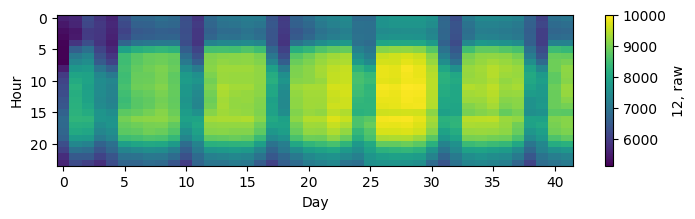

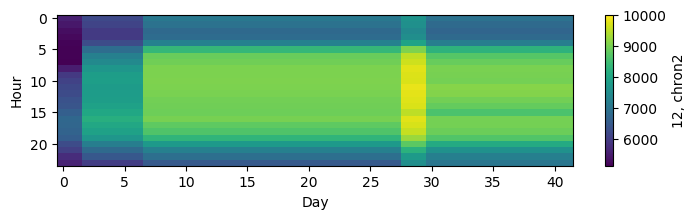

In [37]:
import matplotlib.pyplot as plt

param = '12'
def plotTS(data, periodlength, vmin, vmax, label = 'T [°C]'):
    fig, axes = plt.subplots(figsize = [6, 2], dpi = 100, nrows = 1, ncols = 1)
    stacked, timeindex = unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    axes.set_aspect('auto')  
    axes.set_ylabel('Hour')
    plt.xlabel('Day')
    fig.subplots_adjust(right = 1.2)
    cbar=plt.colorbar(cax)    
    cbar.set_label(label)

plotTS(timeseries_df[param], 24, vmin = timeseries_df[param].min(), vmax = timeseries_df[param].max(), label = param + ", raw"
)
plotTS(timeseries_chron2[param], 24, vmin = timeseries_df[param].min(), vmax = timeseries_df[param].max(), label = param + ", chron2"
)